In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import warnings
import datetime
import GPUtil
import keras
import glob
import cv2
import os

from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.models.resnet import custom_objects
from keras.models import load_model
from matplotlib import rcParams, rc
import matplotlib.lines as mlines
from scipy.misc import imresize
from skimage import io, feature

warnings.filterwarnings("ignore")

Using TensorFlow backend.


**Pipeline deployment of whole images**

In this notebook, we deploy our pipeline for predictions across whole images. 

For ease of presentation, we predict cell types with InceptionV3, instead of the ensemble system (it is straightforward to modify this notebook accordingly).

For computing nodes with multiple GPUs, the first code cell automatically selects the GPU with the lowest memory load (see [here](https://github.com/anderskm/gputil) for further details). 

In [2]:
GPU = GPUtil.getAvailable(order = "memory")[0]                                                                                                  
GPU = str(GPU)                                                                                                                                  
                                                                                                                                                
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

**Select images to predict**

In [3]:
files = glob.glob("./Tiles/*.png") # Change this to the path where you saved your test images. 

files = sorted(files)

print("# Images:", len(files))

# Images: 11


**Import the models (RetinaNet and InceptionV3) used in our computational pipeline**

In [4]:
nuclei_detector = load_model("./models/resnet50_csv_37.h5", custom_objects = custom_objects)

labels_to_names = {0: "nucleus"}

In [5]:
cell_classifier = load_model("./models/inceptionPLA.h5")

**Deploy the whole pipeline on test tiles**

We also store cell counts to estimate local population sizes (to be visualied on top of the figure).

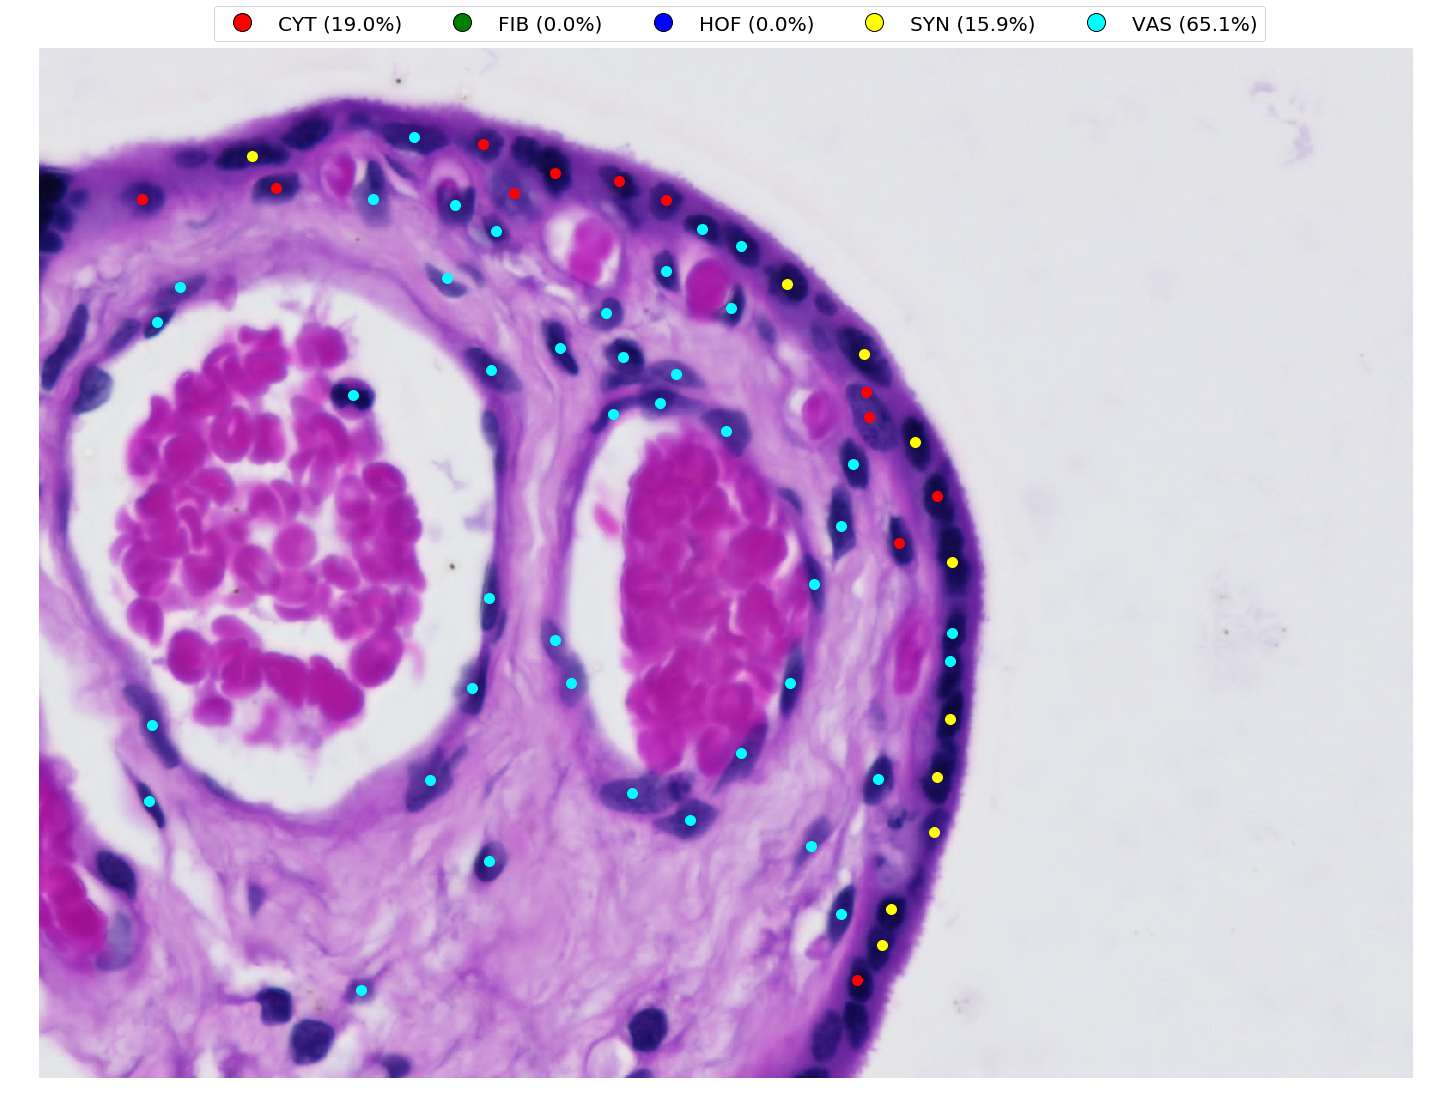

In [6]:
for index, file in enumerate(files[: 1]): # Change to files[: N] for deployment on N images.
    original = io.imread(file)
    image = read_image_bgr(file)
    
    ###
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    ###
    
    image = preprocess_image(image)
    image, scale = resize_image(image)

    _, _, detections = nuclei_detector.predict_on_batch(np.expand_dims(image, axis = 0))

    predicted_labels = np.argmax(detections[0, :, 4:], axis = 1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    detections[0, :, :4] /= scale
    
    ###
    
    plt.figure(figsize = (20, 20))
    
    ###
                
    cyt_count, fib_count, hof_count, syn_count, vas_count = 0, 0, 0, 0, 0
    
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.50:
            continue
        b = detections[0, idx, :4].astype(int)
        x = int((b[0]+b[2])/2)
        y = int((b[1]+b[3])/2)
        window = original[int(y) - 100: int(y) + 100, int(x) - 100: int(x) + 100]
        if window.shape == (200, 200, 3):
            example = imresize(window, (299, 299))
            example = (example/255).astype(np.float32)
            example = np.reshape(example, (1, 299, 299, 3))
            posteriors = cell_classifier.predict(example)
            prediction = np.argmax(posteriors, axis = 1)
            if prediction == 0:
                cyt_plot = plt.scatter(x, y, color = "red", marker = "o", label = "CYT", s = 100)
                cyt_count = cyt_count + 1
            elif prediction == 1:
                fib_plot = plt.scatter(x, y, color = "green", marker = "o", label = "FIB", s = 100)
                fib_count = fib_count + 1
            elif prediction == 2:
                hof_plot = plt.scatter(x, y, color = "blue", marker = "o", label = "HOF", s = 100)
                hof_count = hof_count + 1
            elif prediction == 3:
                syn_plot = plt.scatter(x, y, color = "yellow", marker = "o", label = "SYN", s = 100)
                syn_count = syn_count + 1
            elif prediction == 4:
                ven_plot = plt.scatter(x, y, color = "cyan", marker = "o", label = "VAS", s = 100)
                vas_count = vas_count + 1
    ###
    plt.imshow(original);
    plt.axis("off");
    ###
    total = cyt_count + fib_count + hof_count + syn_count + vas_count
    ###
    CYT_label = "CYT ({:1.1f}%)".format(cyt_count/total * 100)
    FIB_label = "FIB ({:1.1f}%)".format(fib_count/total * 100)
    HOF_label = "HOF ({:1.1f}%)".format(hof_count/total * 100)
    SYN_label = "SYN ({:1.1f}%)".format(syn_count/total * 100)    
    VAS_label = "VAS ({:1.1f}%)".format(vas_count/total * 100)    
    ###
    cyt_line = mlines.Line2D([], [], markeredgecolor = "black", color = "red", marker = "o", linestyle = "None", markersize = 18, label = CYT_label)
    fib_line = mlines.Line2D([], [], markeredgecolor = "black", color = "green", marker = "o", linestyle = "None", markersize = 18, label = FIB_label)
    hof_line = mlines.Line2D([], [], markeredgecolor = "black", color = "blue", marker = "o", linestyle = "None", markersize = 18, label = HOF_label)
    syn_line = mlines.Line2D([], [], markeredgecolor = "black", color = "yellow", marker = "o", linestyle = "None", markersize = 18, label = SYN_label)
    vas_line = mlines.Line2D([], [], markeredgecolor = "black", color = "cyan", marker = "o", linestyle = "None", markersize = 18, label = VAS_label)
    ###
    plt.legend(ncol = 5, handles = [cyt_line, fib_line, hof_line, syn_line, vas_line], prop = {"size": 20}, bbox_to_anchor = (0.9, 1.05))
    plt.tight_layout();